In [1]:
import os 
import cv2
from matplotlib import pyplot as plt
import numpy as np

In [2]:
#Reading the image
file_path = os.path.abspath("sample_images/page_02.png")
image_file = file_path
img = cv2.imread(image_file)

In [3]:
#Display image in line in ipynb

def display(im_path): #takes the image path as input
    dpi = 80
    im_data = plt.imread(im_path)

    height, width  = im_data.shape[:2]
    
    # What size does the figure need to be in inches to fit the image?
    figsize = width / float(dpi), height / float(dpi)

    # Create a figure of the right size with one axes that takes up the full figure
    fig = plt.figure(figsize=figsize)
    ax = fig.add_axes([0, 0, 1, 1])

    # Hide spines, ticks, etc.
    ax.axis('off')

    # Display the image.
    ax.imshow(im_data, cmap='gray')

    plt.show()

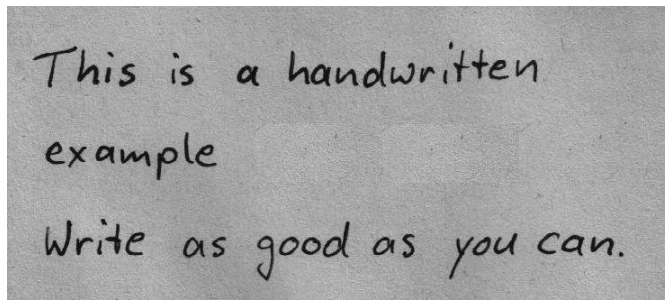

In [4]:
display(image_file)

### Inverting the Image

In [5]:
inverted_image = cv2.bitwise_not(img)
cv2.imwrite(os.path.join("processed_images","inverted.jpg"), inverted_image)

True

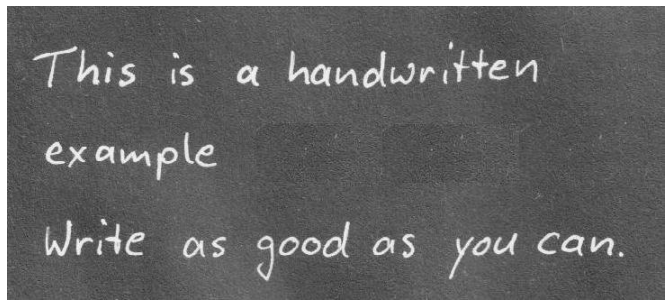

In [6]:
display(os.path.join("processed_images","inverted.jpg"))

### Binarization

In [7]:
#Converting to Gray Scale 

def grayscale_convert(image):
    return cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

In [8]:
gray_image = grayscale_convert(img)
cv2.imwrite(os.path.join("processed_images","gray.jpg"), gray_image)

True

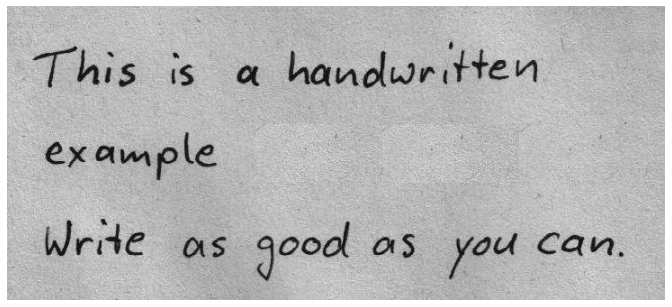

In [9]:
display(os.path.join("processed_images","gray.jpg"))

In [30]:
#Binarization / Black&White convertion 

thresh, im_bw = cv2.threshold(gray_image, 120, 230, cv2.THRESH_BINARY)
cv2.imwrite(os.path.join("processed_images","bw_image.jpg"), im_bw)

True

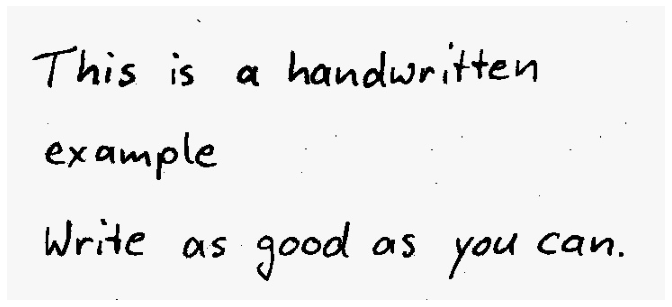

In [31]:
display(os.path.join("processed_images","bw_image.jpg"))

### Noise Removal

In [32]:
#Only if it is too noisy 

def noise_removal(image):
    import numpy as np
    kernel = np.ones((1, 1), np.uint8)
    image = cv2.dilate(image, kernel, iterations=1)
    kernel = np.ones((1, 1), np.uint8)
    image = cv2.erode(image, kernel, iterations=1)
    image = cv2.morphologyEx(image, cv2.MORPH_CLOSE, kernel)
    image = cv2.medianBlur(image, 3)
    return (image)

In [33]:
no_noise = noise_removal(im_bw)
cv2.imwrite(os.path.join("processed_images","no_noise.jpg"), no_noise)

True

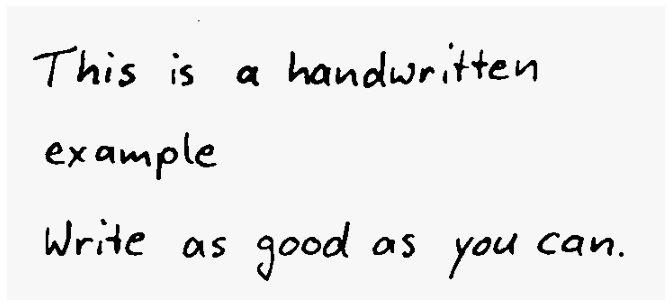

In [34]:
display(os.path.join("processed_images","no_noise.jpg"))

### Dilation and Erosion

In [35]:
#Erosion to thin the font 

def thin_font(image):
    import numpy as np
    image = cv2.bitwise_not(image) #inverting for cv2.erode 
    kernel = np.ones((2,2),np.uint8)
    image = cv2.erode(image, kernel, iterations=1)
    image = cv2.bitwise_not(image)
    return (image)

In [36]:
eroded_image = thin_font(no_noise)
cv2.imwrite(os.path.join("processed_images","eroded_image.jpg"), eroded_image)

True

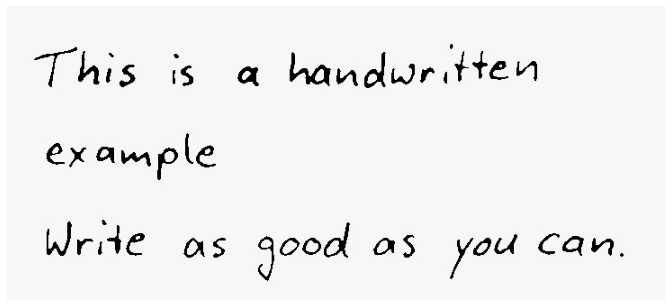

In [37]:
display(os.path.join("processed_images","eroded_image.jpg"))

In [38]:
#Dialte to thicken the font

def thick_font(image):
    image = cv2.bitwise_not(image)
    kernel = np.ones((2,2),np.uint8)
    image = cv2.dilate(image, kernel, iterations=1)
    image = cv2.bitwise_not(image)
    return (image)

In [39]:
dilated_image = thick_font(no_noise)
cv2.imwrite(os.path.join("processed_images","dilated_image.jpg"), dilated_image)

True

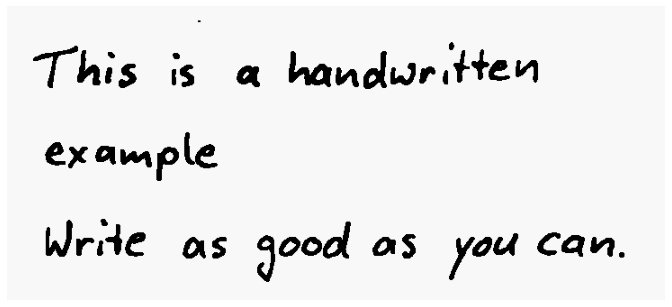

In [40]:
display(os.path.join("processed_images","dilated_image.jpg"))

### Rotating / Deskewing 

In [41]:
# Source: 
#https://becominghuman.ai/how-to-automatically-deskew-straighten-a-text-image-using-opencv-a0c30aed83df

def getSkewAngle(cvImage) -> float:
    # Prep image, copy, convert to gray scale, blur, and threshold
    newImage = cvImage.copy()
    gray = cv2.cvtColor(newImage, cv2.COLOR_BGR2GRAY)
    blur = cv2.GaussianBlur(gray, (9, 9), 0)
    thresh = cv2.threshold(blur, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)[1]

    # Apply dilate to merge text into meaningful lines/paragraphs.
    # Use larger kernel on X axis to merge characters into single line, cancelling out any spaces.
    # But use smaller kernel on Y axis to separate between different blocks of text
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (30, 5))
    dilate = cv2.dilate(thresh, kernel, iterations=2)

    # Find all contours
    contours, hierarchy = cv2.findContours(dilate, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
    contours = sorted(contours, key = cv2.contourArea, reverse = True)
    for c in contours:
        rect = cv2.boundingRect(c)
        x,y,w,h = rect
        cv2.rectangle(newImage,(x,y),(x+w,y+h),(0,255,0),2)

    # Find largest contour and surround in min area box
    largestContour = contours[0]
    print (len(contours))
    minAreaRect = cv2.minAreaRect(largestContour)
    cv2.imwrite("temp/boxes.jpg", newImage)
    # Determine the angle. Convert it to the value that was originally used to obtain skewed image
    angle = minAreaRect[-1]
    if angle < -45:
        angle = 90 + angle
    return -1.0 * angle
# Rotate the image around its center
def rotateImage(cvImage, angle: float):
    newImage = cvImage.copy()
    (h, w) = newImage.shape[:2]
    center = (w // 2, h // 2)
    M = cv2.getRotationMatrix2D(center, angle, 1.0)
    newImage = cv2.warpAffine(newImage, M, (w, h), flags=cv2.INTER_CUBIC, borderMode=cv2.BORDER_REPLICATE)
    return newImage

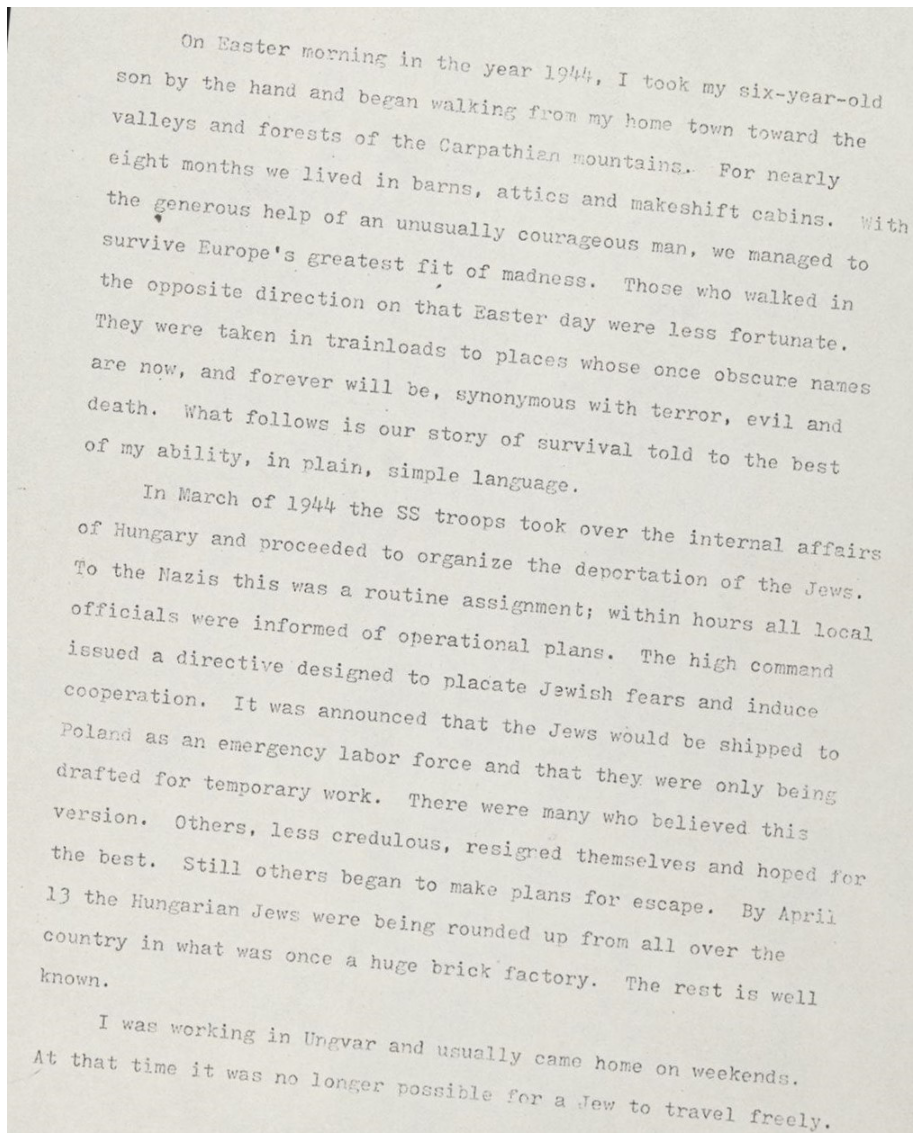

In [49]:
new = cv2.imread(os.path.join("sample_images","page_01_rotated.jpg"))

display(os.path.join("sample_images","page_01_rotated.jpg"))

In [50]:
# Deskew image

def deskew(cvImage):
    angle = getSkewAngle(cvImage)
    return rotateImage(cvImage, -1.0 * angle)


fixed = deskew(new)
cv2.imwrite(os.path.join("processed_images","rotated_fixed.jpg"), fixed)

28


True

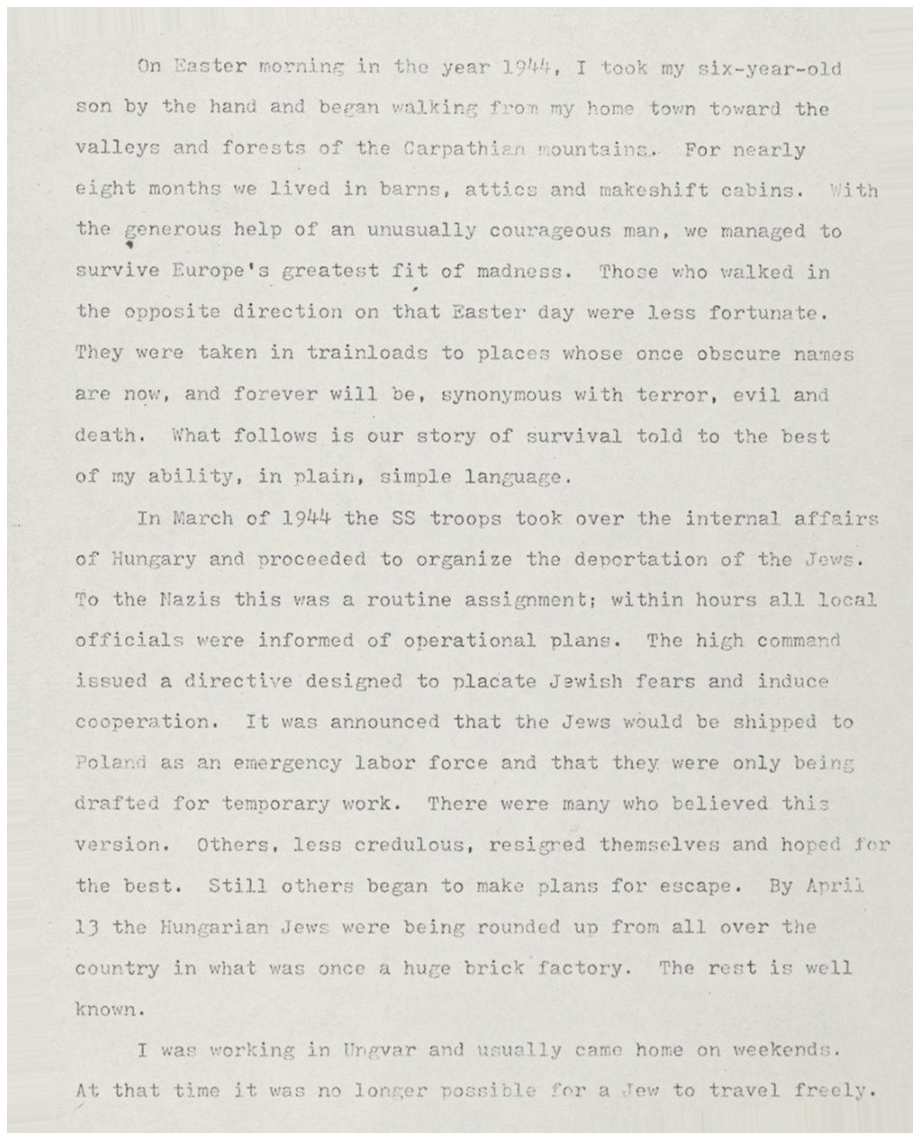

In [51]:
display(os.path.join("processed_images","rotated_fixed.jpg"))

### Removing the border

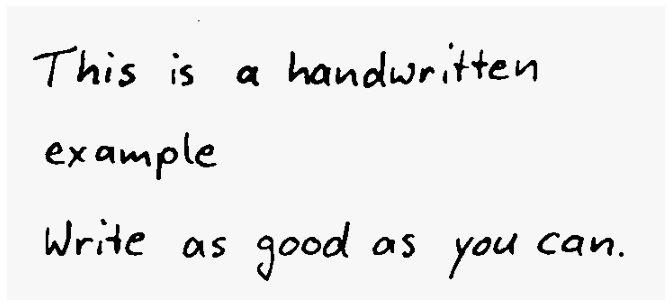

In [45]:
display(os.path.join("processed_images","no_noise.jpg"))

In [46]:
def remove_borders(image):
    contours, heiarchy = cv2.findContours(image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cntsSorted = sorted(contours, key=lambda x:cv2.contourArea(x))
    cnt = cntsSorted[-1]
    x, y, w, h = cv2.boundingRect(cnt)
    crop = image[y:y+h, x:x+w]
    return (crop)

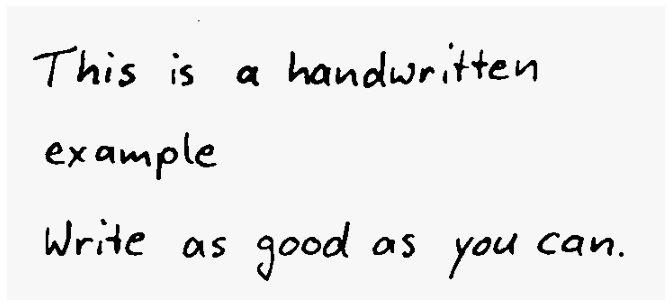

In [47]:
no_borders = remove_borders(no_noise)
cv2.imwrite(os.path.join("processed_images","no_borders.jpg"), no_borders)
display(os.path.join("processed_images",'no_borders.jpg'))